In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/train.csv", index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
def process(df):
  df = df.drop(['MiscFeature', 'PoolQC', 'Alley', 'Fence' ], axis=1) #drop features with too much null values
  
  numDf = df.select_dtypes(include='number').columns #select number features
  for col in numDf:
    df[col] = df[col].fillna(df[col].median()) #process numeric columns (fill Na/Nan with median)

  strDf = df.select_dtypes(include='object').columns #select string features
  for col in strDf:
    df[col] = df[col].fillna(df['LotShape'].value_counts().idxmax()) #process string columns (fill Na/Nan with most commun string)
    df[col] = pd.factorize(df[col])[0] #factorize string columns
  
  return df

  

In [5]:
pdf = process(df)
pdf.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
2,20,0,80.0,9600,0,0,0,0,1,0,...,0,0,0,0,0,5,2007,0,0,181500
3,60,0,68.0,11250,0,1,0,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
4,70,0,60.0,9550,0,1,0,0,2,0,...,272,0,0,0,0,2,2006,0,1,140000
5,60,0,84.0,14260,0,1,0,0,1,0,...,0,0,0,0,0,12,2008,0,0,250000


##Exploratory Data Analysis

In [6]:
correlation = pdf.corr()
correlation

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
MSSubClass,1.000000,0.286937,-0.356718,-0.139781,0.024969,-0.115361,-0.018947,-0.022844,-0.069160,-0.025672,...,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,0.012874,-0.015047,-0.084284
MSZoning,0.286937,1.000000,-0.228998,-0.161640,0.039678,-0.167918,-0.013396,-0.011167,-0.094747,-0.043444,...,0.075025,-0.045145,-0.067541,-0.029301,-0.021573,0.022231,-0.010621,0.058948,0.068705,-0.116047
LotFrontage,-0.356718,-0.228998,1.000000,0.304522,0.037349,0.191420,0.087425,-0.001027,0.120529,0.065603,...,0.010287,0.061945,0.037655,0.180819,-0.000255,0.010451,0.006380,0.007377,0.070884,0.334771
LotArea,-0.139781,-0.161640,0.304522,1.000000,0.197131,0.315484,0.258792,0.010123,0.160976,0.436868,...,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,-0.013882,0.000199,0.263843
Street,0.024969,0.039678,0.037349,0.197131,1.000000,0.010129,0.097236,-0.001682,0.004458,0.179360,...,-0.023082,-0.007473,0.033160,-0.004413,0.022733,-0.003690,0.025043,0.021171,0.022919,-0.041036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,-0.013585,0.022231,0.010451,0.001205,-0.003690,0.026617,0.063280,-0.051552,-0.018916,0.007072,...,-0.028887,0.029474,0.023217,-0.033737,-0.006495,1.000000,-0.145721,0.040201,0.054679,0.046432
YrSold,-0.021407,-0.010621,0.006380,-0.014261,0.025043,-0.037391,-0.026117,0.023353,0.002288,-0.002305,...,-0.009916,0.018645,0.010694,-0.059689,0.004906,-0.145721,1.000000,-0.021683,-0.123720,-0.028923
SaleType,0.012874,0.058948,0.007377,-0.013882,0.021171,0.001435,-0.014537,0.057455,0.012120,-0.056680,...,-0.009259,-0.002600,-0.029731,-0.009887,-0.014143,0.040201,-0.021683,1.000000,0.232149,0.072896
SaleCondition,-0.015047,0.068705,0.070884,0.000199,0.022919,-0.004773,0.062826,0.019173,-0.013638,0.017187,...,-0.048306,-0.001324,-0.028190,0.068578,-0.032655,0.054679,-0.123720,0.232149,1.000000,0.142503


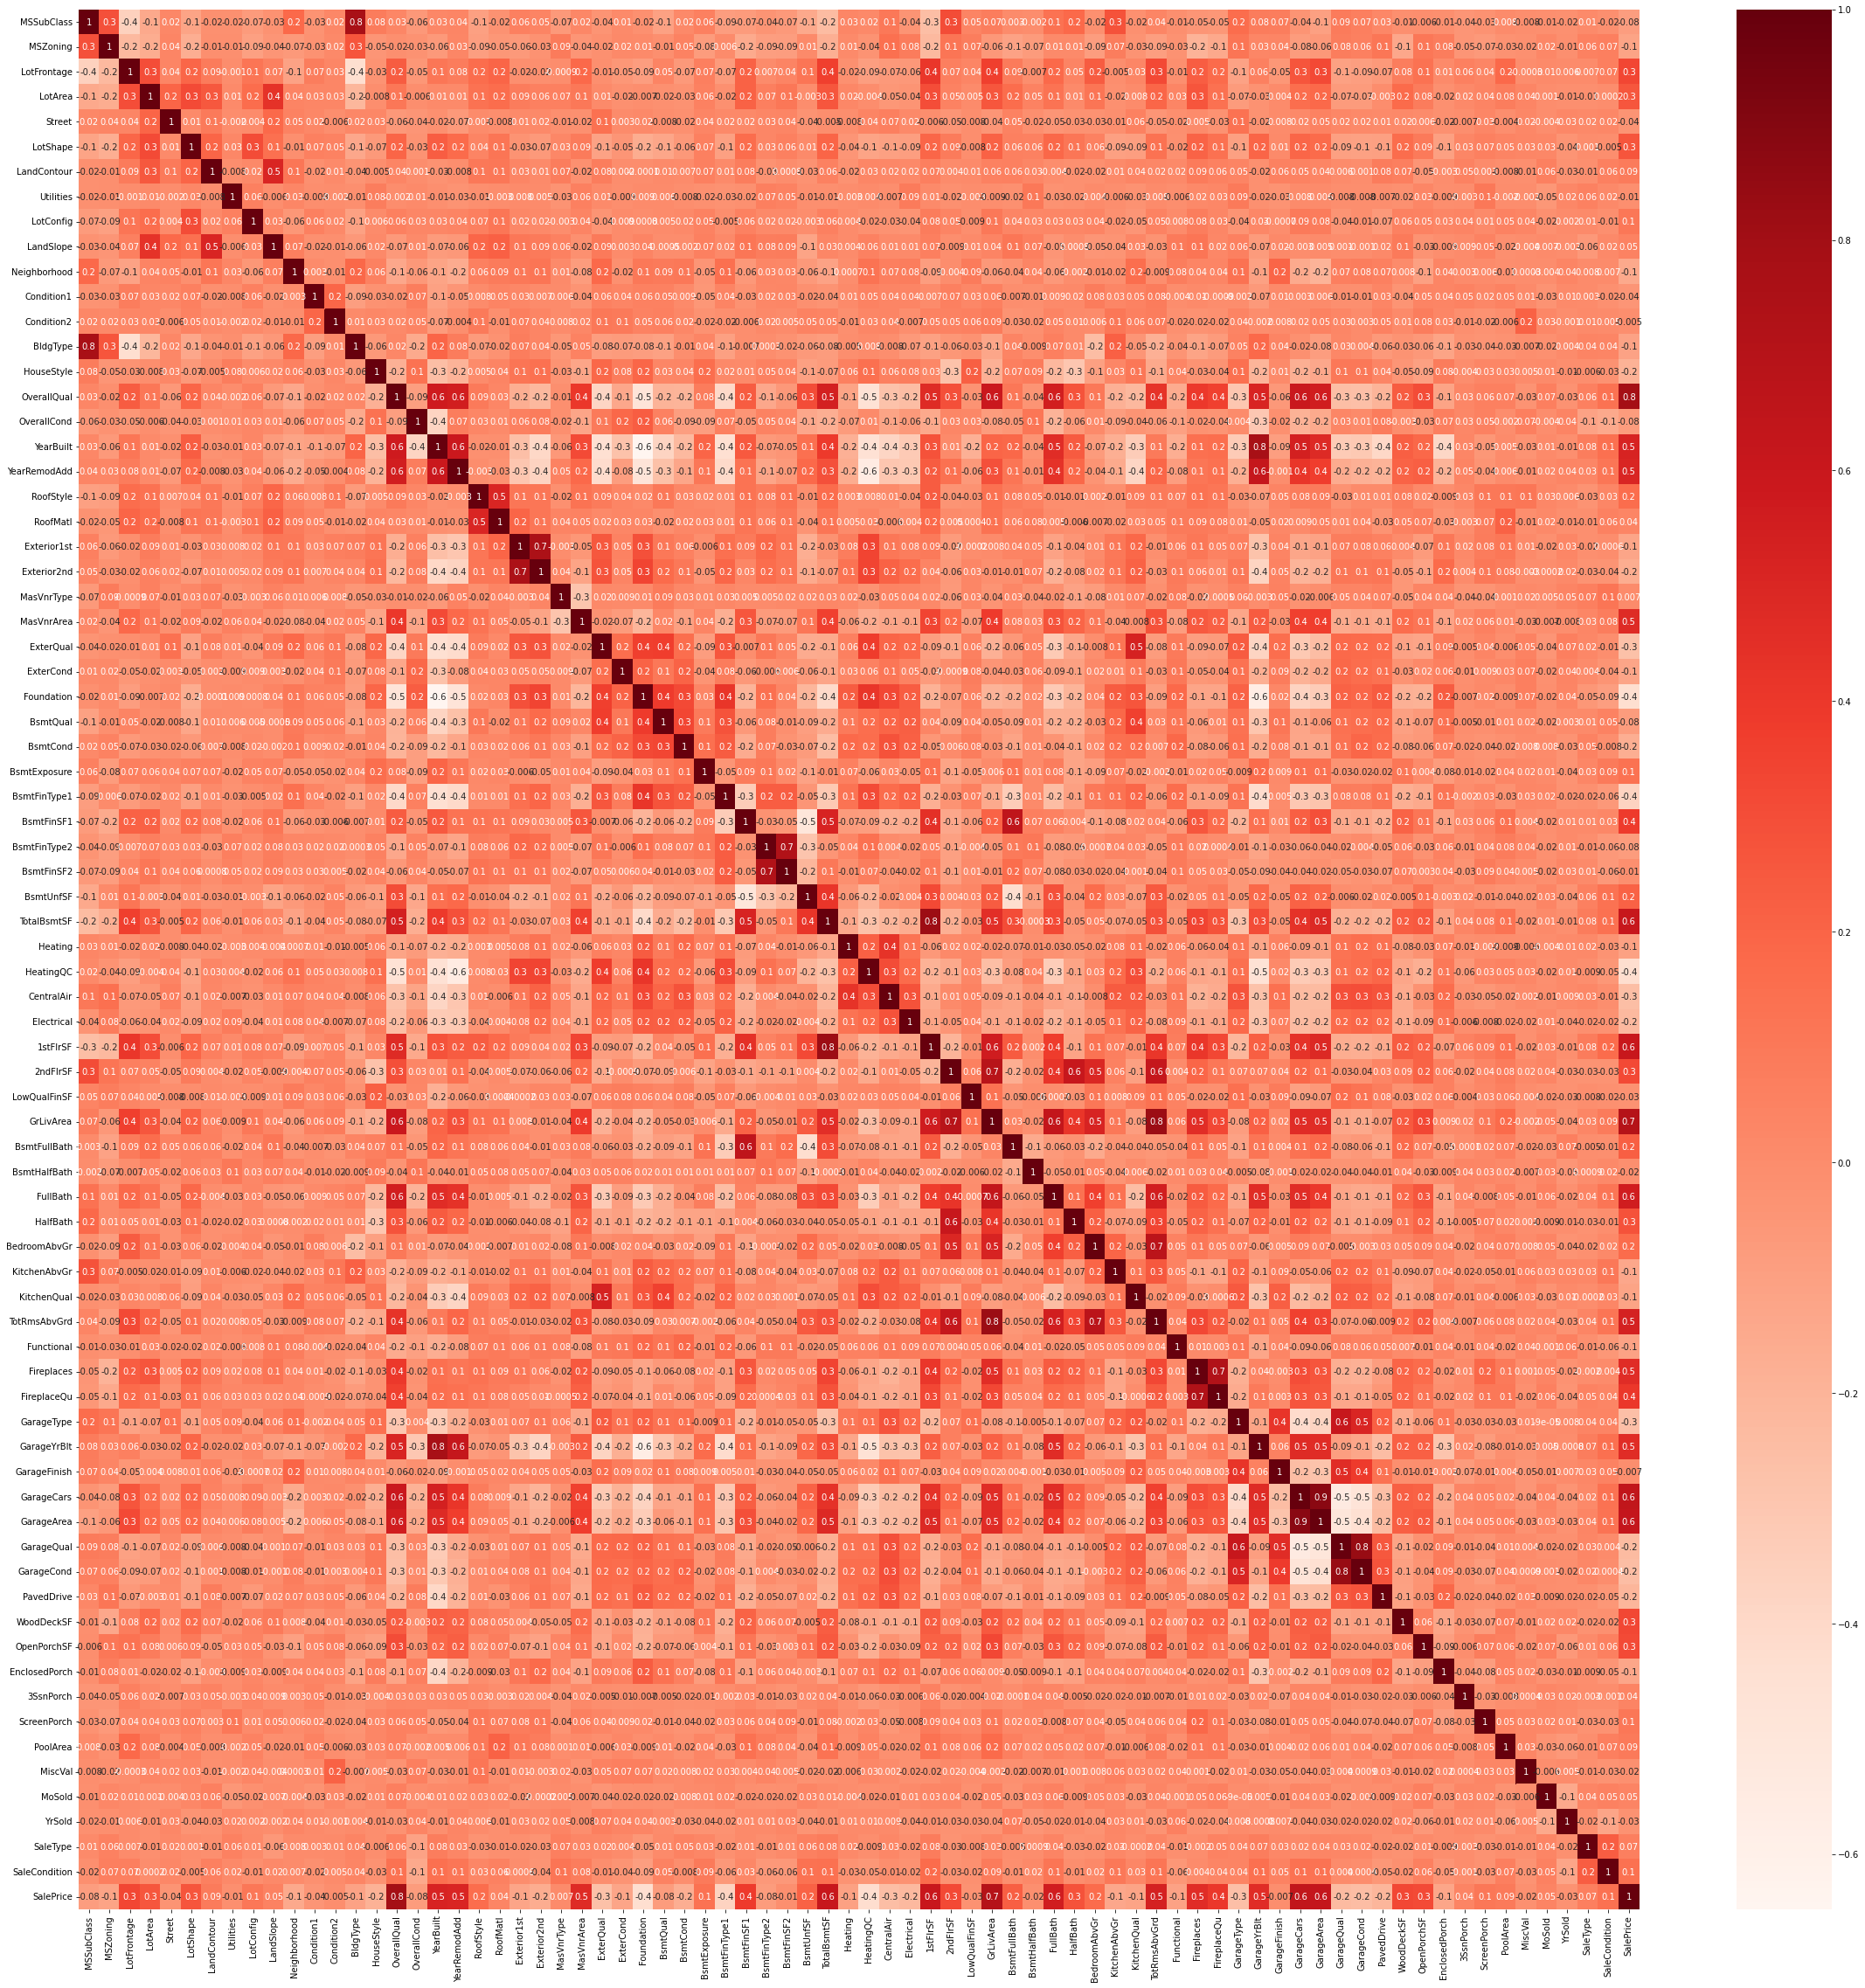

In [7]:
plt.figure(figsize=(40,40))
sns.heatmap(data=correlation, annot=True, cmap='Reds', fmt='.1g')
plt.show()

In [8]:
#Extracting features with high correlation to the target feature (>=0.5)
corr = [c for c in correlation.loc[correlation['SalePrice'] >= 0.5].index]
corr[:-1]

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

In [9]:
edadf = pdf[corr]
edadf.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
Id,,,,,,,,,,,
1,7,2003,2003,856,856,1710,2,8,2,548,208500
2,6,1976,1976,1262,1262,1262,2,6,2,460,181500
3,7,2001,2002,920,920,1786,2,6,2,608,223500
4,7,1915,1970,756,961,1717,1,7,3,642,140000
5,8,2000,2000,1145,1145,2198,2,9,3,836,250000


<Figure size 1440x1080 with 0 Axes>

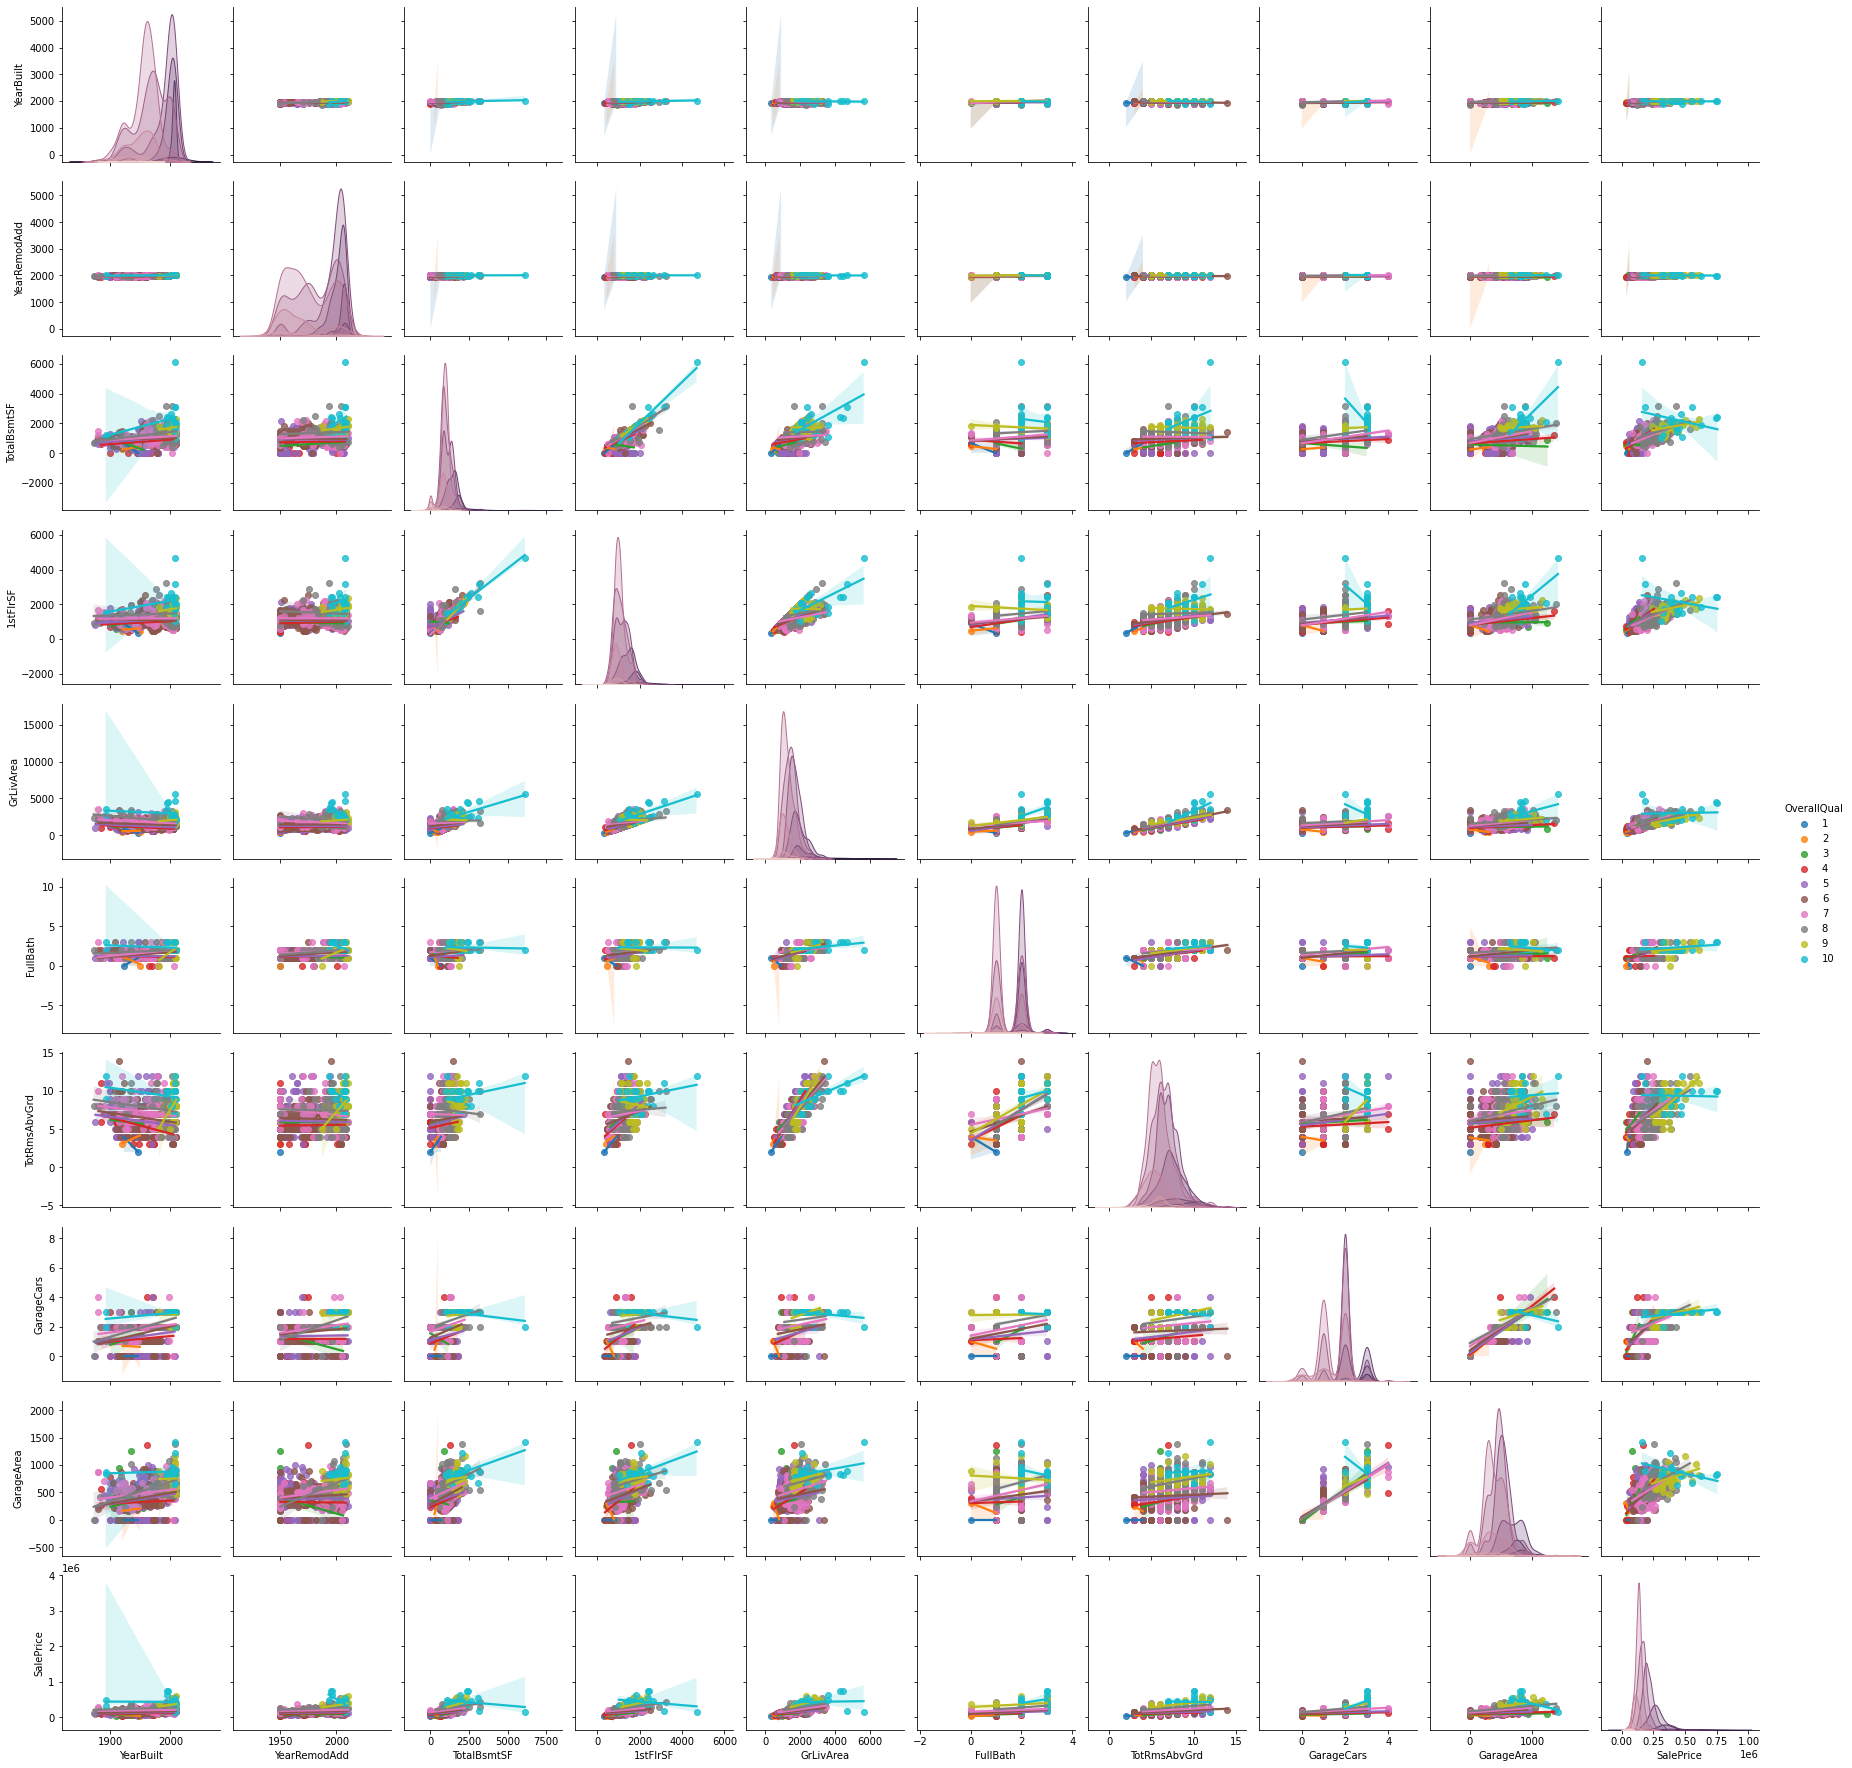

In [10]:
#pair plotting between all features to find positive high correlation 
plt.figure(figsize=(20,15))
sns.pairplot(data=edadf,diag_kind='kde',hue='OverallQual',kind='reg')
plt.show()

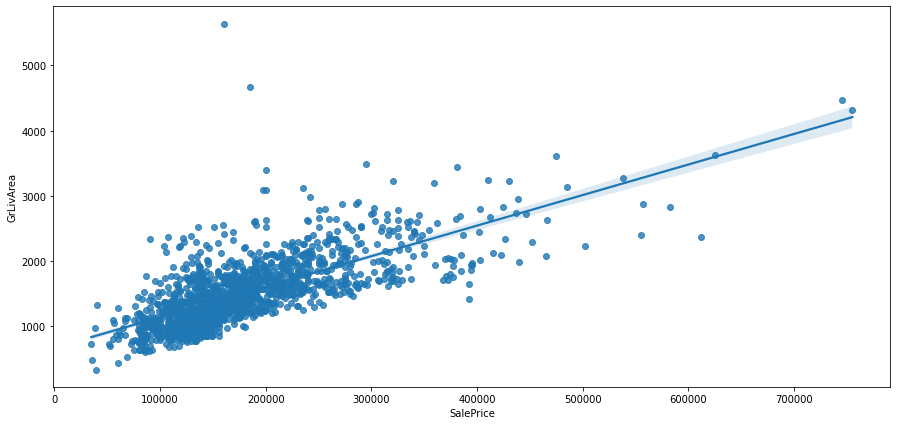

In [11]:
plt.figure(figsize=(15,7))
sns.regplot(data=edadf, x='SalePrice', y='GrLivArea')
plt.show() #Relation between this feature and target feature is seen here

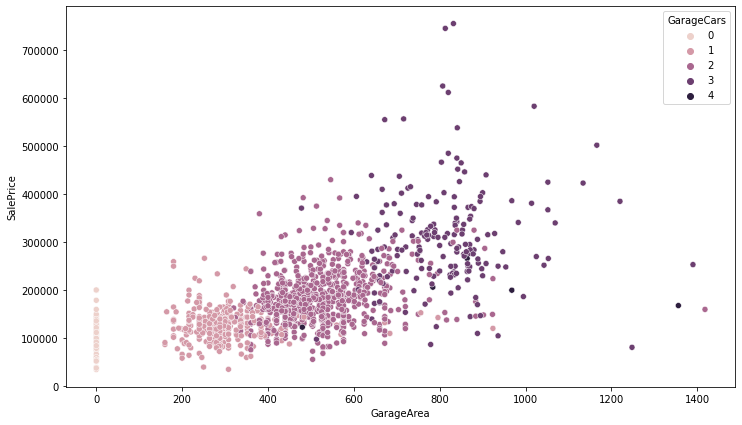

In [12]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=edadf, x='GarageArea', hue='GarageCars', y='SalePrice')
plt.show()

#Prediction Part

In [14]:
#extract and process test data
dfs = pd.read_csv("/content/test.csv", index_col='Id')
pdfs = process(dfs)
pdfs.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,0,80.0,11622,0,0,0,0,0,0,...,0,0,0,120,0,0,6,2010,0,0
1462,20,1,81.0,14267,0,1,0,0,1,0,...,36,0,0,0,0,12500,6,2010,0,0
1463,60,1,74.0,13830,0,1,0,0,0,0,...,34,0,0,0,0,0,3,2010,0,0
1464,60,1,78.0,9978,0,1,0,0,0,0,...,36,0,0,0,0,0,6,2010,0,0
1465,120,1,43.0,5005,0,1,1,0,0,0,...,82,0,0,144,0,0,1,2010,0,0


In [62]:
#Extract only the important features
edadfs = pdfs[corr[:-1]]
edadfs

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
Id,,,,,,,,,,
1461,5,1961,1961,882.0,896,896,1,5,1.0,730.0
1462,6,1958,1958,1329.0,1329,1329,1,6,1.0,312.0
1463,5,1997,1998,928.0,928,1629,2,6,2.0,482.0
1464,6,1998,1998,926.0,926,1604,2,7,2.0,470.0
1465,8,1992,1992,1280.0,1280,1280,2,5,2.0,506.0
...,...,...,...,...,...,...,...,...,...,...
2915,4,1970,1970,546.0,546,1092,1,5,0.0,0.0
2916,4,1970,1970,546.0,546,1092,1,6,1.0,286.0
2917,5,1960,1996,1224.0,1224,1224,1,7,2.0,576.0


In [65]:
X = edadf.drop('SalePrice', axis=1)
y = edadf['SalePrice']
X

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
Id,,,,,,,,,,
1,7,2003,2003,856,856,1710,2,8,2,548
2,6,1976,1976,1262,1262,1262,2,6,2,460
3,7,2001,2002,920,920,1786,2,6,2,608
4,7,1915,1970,756,961,1717,1,7,3,642
5,8,2000,2000,1145,1145,2198,2,9,3,836
...,...,...,...,...,...,...,...,...,...,...
1456,6,1999,2000,953,953,1647,2,7,2,460
1457,6,1978,1988,1542,2073,2073,2,7,2,500
1458,7,1941,2006,1152,1188,2340,2,9,1,252


In [66]:
y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

In [17]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': (200,500,750),
          'max_depth': (5,10,15),
          'criterion': ('squared_error', 'absolute_error', 'poission')
}

#MODEL1
model1 = RandomForestRegressor()
grid = GridSearchCV(estimator=model1, param_grid=params)
grid.fit(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", 

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ('squared_error', 'absolute_error',
                                       'poission'),
                         'max_depth': (5, 10, 15),
                         'n_estimators': (200, 500, 750)})

In [48]:
#select best params
bparams = grid.best_params_
model1_2 = RandomForestRegressor(
    criterion = bparams['criterion'],
    max_depth = bparams['max_depth'],
    n_estimators = bparams['n_estimators']
)
model1_2.fit(X, y)

pred = model1_2.predict(X)
pred.shape

(500,)

In [49]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y, pred)
r2 = r2_score(y, pred)
print(mape, r2)

0.057407397987920605 0.9716816790953999


In [67]:
#MODEL2
model2 = GradientBoostingRegressor(n_estimators=700)
model2.fit(X, y)
pred = model2.predict(X)

In [68]:
mape_2 = mean_absolute_percentage_error(y, pred)
r2_2 = r2_score(y, pred)
print(mape_2, r2_2)

0.047362122931858 0.9849358743947917


In [69]:
#MODEL3
model3 = LinearRegression()
model3.fit(X, y)
pred = model3.predict(X)

In [70]:
mape_3 = mean_absolute_percentage_error(y, pred)
r2_3 = r2_score(y, pred)
print(mape_3, r2_3)

0.14323654966124852 0.7736928402773303


In [71]:
#MODEL4
from sklearn.model_selection import train_test_split

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.8)
model4 = XGBRegressor(n_estimators=1500, max_depth=10)
model4.fit(Xt, yt)
pred = model4.predict(Xv)

[15:21:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [72]:
mape_4 = mean_absolute_percentage_error(yv, pred)
r2_4 = r2_score(yv, pred)
print(mape_4, r2_4)

0.13040986475639207 0.7814106100906466


In [73]:
test_pred = model4.predict(edadfs)
final_pred = pd.DataFrame(test_pred, index=dfs.index)
final_pred.columns = ['SalePrice']
final_pred.head()

,SalePrice
Id,
1461,128142.179688
1462,155339.125000
1463,181156.890625
1464,190722.078125
1465,183305.000000
